# 1_ Entrenamiento/ Trainning Notebook


   El modelo de ML utiliza para entrenar un dataset compuesto por imágenes y máscaras para el entrenamiento. Estas ultimas son imagenes binarias que delimitan el objeto de interés, teniendo píxeles con valor 1 donde esta y 0 donde no. 
   
   *The ML model uses a dataset with images and masks to train. Masks are binary images that delimited the interest object with pixel values equal to 1 where the interest object is and 0 where it isn't.*

In [24]:
#!pip install pysatproc

In [1]:
from unetseg.train import TrainConfig, train
from unetseg.evaluate import plot_data_generator
import os
import matplotlib.pyplot as plt

In [2]:
#General
ZONE = ""
RESO = ""
YEAR = ""

GT_FILE="annotations_lowresolution_small_4326.geojson"
AOI_FILE="aoi_"

#Buckets
PROYECT=""
BUCKET_IMG_TRAIN = f"gs://dym-quilmes-trucks-temp/{PROYECT}/imagenes/{ZONE}/{RESO}/{YEAR}/*.tif" 
BUCKET_GT= f'gs://dym-quilmes-trucks-temp/{PROYECT}/asentamientos_informales/data/shp/gt/{GT_FILE}'
BUCKET_AOI=f'gs://dym-quilmes-trucks-temp/{PROYECT}/asentamientos_informales/data/shp/gt/{AOI_FILE}'

#Paths
BASE_PATH = "./.."
PATH_TRAIN_IMAGES = f'{BASE_PATH}/images/{ZONE}/{RESO}/{YEAR}/'
PATH_GT=f'{BASE_PATH}/data/shp/gt/{ZONE}/{RESO}/

In [3]:
#satproc
SIZE =160
STEP_SIZE = 40
CLASSES = 'A'
RESCALE_MODE = "values --min 0 --max 0.3"    
#train
INFO = "classA"

#unet
INPUT_SIZE=160
N_CHANNELS=3
CLASS_WEIGHT = [1]
STEP_PER_EPOCH = 100
N_CLASSES = 1
VERSION='v1' 



### Descarga desde buckets/ Download from buckets

**Descarga de imagenes**  
*Images download*

In [ ]:
!mkdir -p $PATH_TRAIN_IMAGES

!gsutil -m cp -r $BUCKET_IMG_TRAIN   $PATH_TRAIN_IMAGES

**Descarga de anotaciones**  
*Ground truth download*

In [5]:
!mkdir -p $PATH_GT

!gsutil -m cp -r $BUCKET_GT   $PATH_GT

Copying gs://dym-quilmes-trucks-temp/I2UD/asentamientos_informales/data/shp/gt/annotations_lowresolution_small_4326.geojson...
/ [1/1 files][103.2 KiB/103.2 KiB] 100% Done                                    
Operation completed over 1 objects/103.2 KiB.                                    


**Descarga de aoi**  
*Aoi download*

In [ ]:
!gsutil -m cp -r $BUCKET_AOI   $PATH_GT

## Generacion del data set de entrenamiento/ Training dataset generation

   En esta etapa generamos el dataset de entrenamiento mediante el uso de **Satproc**.  Esta herramienta nos permite generar el dataset con todas las caracteristicas necesarias para el modelo: tamaño , cantidad de imagenes, rango de valores, etc.
   
   *In this stage the training dataset is generated using **Satproc**.  This tool generates the dataset with characteristics needed for the model: size, number of images, value range, etc.*

### Satproc

Con la herramienta **satproc_extract_chips** se generan, a partir de las imágenes descargadas del bucket, imágenes (chips) generalmente mas pequeñas y máscaras (utilizando las anotaciones de verdad de campo).

*From the downloaded images **satproc_extract_chips** tool generates smaller images (chips) and masks, using the ground truth*

**OBS** : tanto las imagenes como el archivo vectorial deben tener la misma georeferencia, por ejemplo 4326.

**Observation:** *images and vectorial file (gt) should have the same georeference, for instance, EPSG:4326* 

In [4]:
path_to_files= f'{PATH_TRAIN_IMAGES}*.tif' #carpeta a las imagenes/ images folder
output_folder=os.path.join('./../dataset/data_train/',ZONE,RESO,YEAR,str(SIZE)+'_'+str(STEP_SIZE)+'/')  #carpeta de destino del dataset/ dataset destination folder
vector_file = f'{PATH_GT}{GT_FILE}' # archivo vectorial de verdad de campo / ground truth vector file 
vector_file_aoi = f'{PATH_GT}{AOI_FILE}' #archivo vectorial con las zonas de interes/ area of interest vector file

Ejecutamos satproc

*Satproc execution*

In [10]:
#!satproc_extract_chips --help


In [13]:
!satproc_extract_chips \
                $path_to_files \
                -o $output_folder \
                --size $SIZE \
                --step-size $STEP_SIZE \
                --aoi $vector_file_aoi \
                --labels $vector_file \
                --label-property 'class' \
                --classes $CLASSES \
                --rescale \
                --rescale-mode $RESCALE_MODE

Rasters: 100%|###################################| 1/1 [02:28<00:00, 148.02s/it]


###### Los argumentos/ Arguments:

* **path_to_files:** es la ruta a las imágenes / *images path*

* **o:** es la ruta de destino / *destination path*

Recomendamos que dicha ruta sea descriptiva, por ejemplo “data_train/120_40/ ” describe : Data_train → datos usados para entrenar; 120_40 → <tamaño de la imagen >_ <tamaño del step-size> 

We recommend use a descriptive path. For instances: "./../data_train/120_40/" describes: data_train → data use for train; 120_40 → < image size >_< step size >.

* **size:** tamaño de las imágenes resultantes o chips (las imágenes son cuadradas) / *chips size (chips are square images)*
* **step-size:** paso del proceso. Debe ser menor o igual a *size*. Si *step-size* es igual que el *size* entonces no hay overlap en las imágenes resultantes. / *process step. It should be less or equal to 'size'. If it's equal to size, there isn't an overlap in the resulting images*

En ocaciones es útil para el entrenamiento generar los chips con un overlap de este modo tenemos más datos para entrenar. / *Sometimes, it's useful generating overlaping images for the training, because the overlaping increase the number of images in the training dataset*.


* **label-property:** nombre del campo donde se define cada categoría (solo se usa para el entrenamiento) / *field name where the classes are defined (it's only used for training dataset).*

* **classes:** nombres de las clases (como aparecen en el geojson), separados por espacios / *classes names (as they appear in the geojson file), separated by spaces*

* **aoi:** ruta al archivo vectorial donde están definidas las anotaciones. Al definir una region de interés solo se procesan las imágenes que interceptan esas anotaciones / *aoi file path. When an area of interest(area where annotations are defined) is stablished, Satproc only process that area of the image*

* **rescale:** lleva los valores de las bandas a 0-255 / *rescale band values to 0-255*

Este comando va a generar dos carpetas en la ruta de destino : “images” y “extent”. Los archivos de la primera van a ser de tipo Tiff de 3 bandas (rgb) y los de la segunda van a ser, también, de tipo Tiff pero de N bandas donde N representa el número de clases, en este caso sólo una. Y donde cada una de las bandas es una máscara binaria

*This command generate two folder in the destination path: "images" and "extent". Files in the first one are Tiff files with 3-bands (RGB). Secondly, files from the second folder are Tiff type but with N-bands, where N is the number of classes. Each band is a binary image.*

## Entrenamiento/ Training

Entrenamos el modelo utilizando los datasets creados en el paso previo. El modelo es una red neuronal CNN basado en la arquitectura U-Net. Este considera las imágenes y las máscaras binarias como inputs y genera una imagen con la probabilidad de encontrar al objeto de interés.

*We train the model using the datasets (images and masks) created with Satproc. The model is a convolutional neural network (CNN) with U-Net architecture. It uses images and binary masks as inputs and generates an image with the probability of find the object of interest.*

En esta etapa debemos definir la configuración del modelo de ML. 

*In this stage, we define the model configuration*

In [5]:
model_name = f'UNet_{ZONE}_{INPUT_SIZE}x{INPUT_SIZE}_{str(SIZE)}_{str(STEP_SIZE)}_spe{str(STEP_PER_EPOCH)}_{N_CHANNELS}N_fecha{YEAR}_{INFO}_{VERSION}.h5'

In [6]:
model_name

'UNet_sula_160x160_160_40_spe100_3N_fecha2020_classA_v6.h5'

In [7]:
config = TrainConfig(width   = INPUT_SIZE,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc; y no menor a 80) // image size processed by the Unet (It must be a multiple of 16 bigger than 80)
                     height  = INPUT_SIZE,
                     n_channels   = N_CHANNELS,  #  número de canales de la imagen, rgb -> 3 // number of bands of the image
                     n_classes    = N_CLASSES, # número de clases a clasificar// number of classes to classify
                     apply_image_augmentation = True, #  si es True, amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes (rotación,)//If it's True, increase the dataset size by the creation of new images from little modification of the orginal images (rotation) 
                     seed       = 42,
                     epochs     = 20, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento// Number of times the full dataset could be processed in the training
                     batch_size = 16, #Cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)//  Number of training examples utilized in one iteration.
                     steps_per_epoch  = STEP_PER_EPOCH, #  Típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation. // Normally, is equal to the ratio between the dataset size and the batch size. If it's bigger, increase the number of images created by image_augmentation .
                     early_stopping_patience  = 5, # a medida que entrena se guardan los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 5 iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente. // After each epoch, the training results are saved. If there isn't variation of the error 5 iterations after the saved model, the training proccess is over.
                     validation_split   = 0.1, # se divide la muestra en training (90% de los datos) y validation (10% de los datos) para calcular el error durante el proceso de entrenamiento.// The training dataset is divided: 90% to train the model and 10% to validate it (to calculate the error).
                     test_split         = 0.1, # Cantidad de imágenes del dataset test // Number of images in the test dataset
                     images_path        = output_folder,#ruta a las imágenes generadas con Satproc //Satproc images destination path
                     model_path         = os.path.join(BASE_PATH,'data/weights/', model_name),# ruta del modelo entrenado // Trained model path
                     model_architecture = 'unet', #Arquitectura de la red // Neural network architecture
                     evaluate           = True  ,
                     class_weights      = CLASS_WEIGHT) 

**Obs**: Es util usar un nombre para el archivo de pesos que de información sobre los parametros de entrenamiento. por ejemplo: < modelo >_< proyecto >_< dim_de_las_imagenes >_< size >_< step_size >_< step_per_epoch >.h5 o similares

*It's useful named the model using information about training parameters. For instances:  < model >_< proyect >_< images_dimension >_< size >_< step_size >_< step_per_epoch >.h5 or similar.*


Podemos visualizar alguna de las imágenes y máscaras del dataset de entrenamiento. A la izquierda se muestra la imágen y a la derecha la máscara.

*We can visualize some images and mask from the training dataset. (Left: image, Right: mask.)*

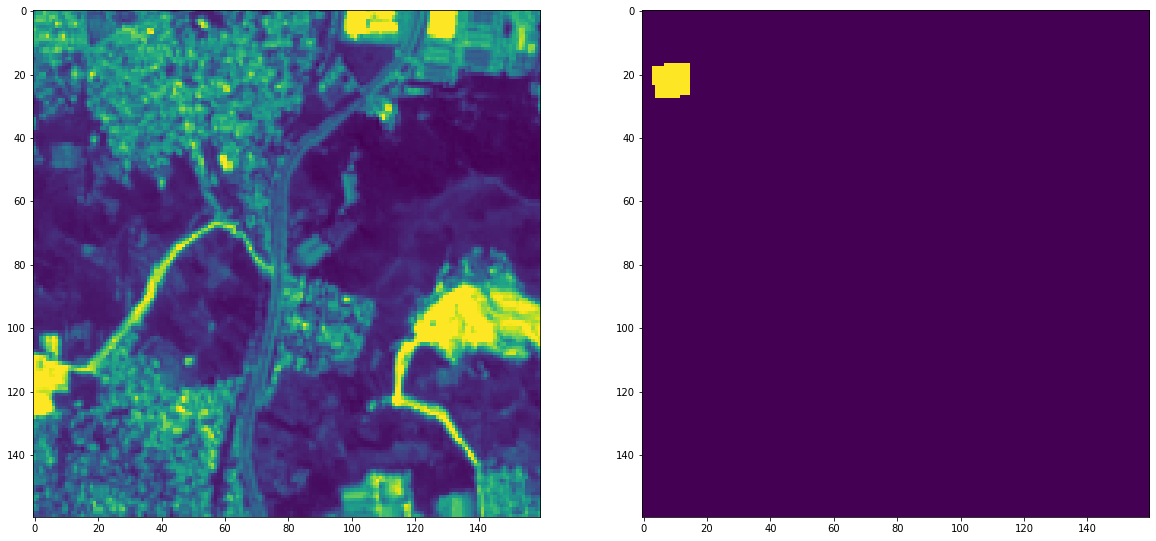

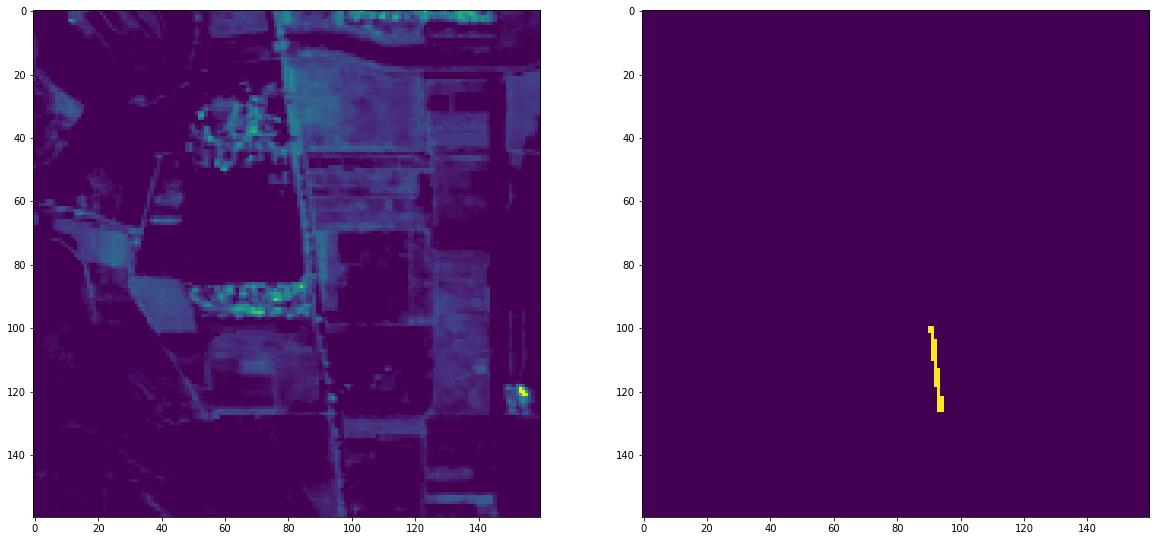

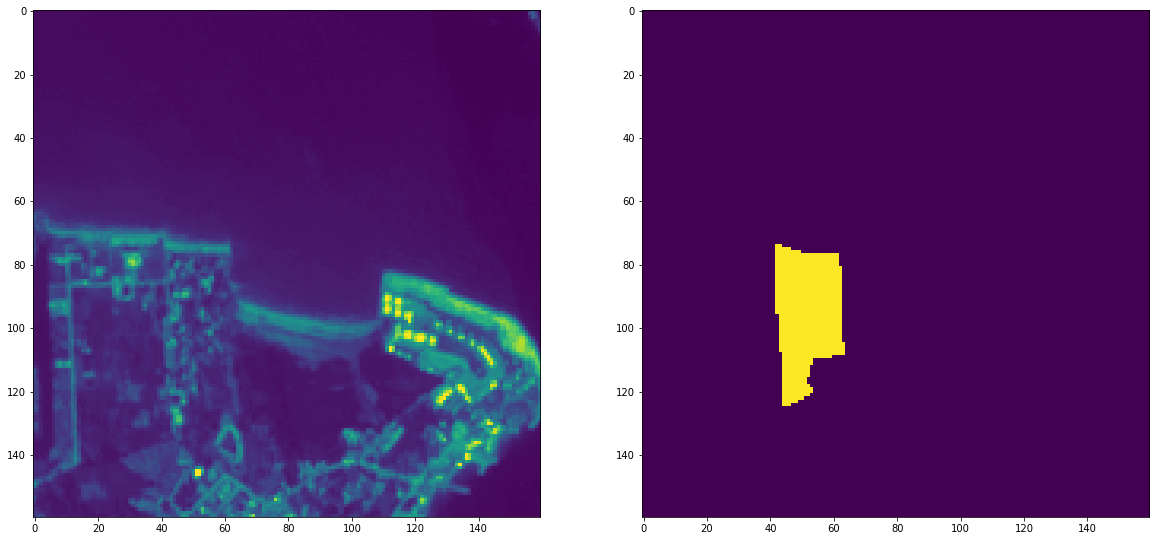

In [9]:
plot_data_generator(num_samples=3, fig_size=(20, 20), train_config=config,img_ch =3)

Corremos el entrenamiento. 

*Running the training process*

In [11]:
res_config = train(config)

2022-06-28 16:03:25.502975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 16:03:25.512961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 16:03:25.513793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 16:03:25.515340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

2022-06-28 16:03:33.376254: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8202
2022-06-28 16:03:33.844065: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-28 16:03:33.847311: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-28 16:03:33.847355: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-06-28 16:03:33.847852: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-28 16:03:33.847943: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


100/100 [==============================] - ETA: 0s - loss: 0.1486 - mean_io_u: 0.4860
Epoch 1: val_loss improved from inf to 0.11792, saving model to ./../data/weights/UNet_sula_160x160_160_40_spe100_3N_fecha2020_classA_v6.h5
100/100 [==============================] - 86s 764ms/step - loss: 0.1486 - mean_io_u: 0.4860 - val_loss: 0.1179 - val_mean_io_u: 0.4855
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.1160 - mean_io_u: 0.4854
Epoch 2: val_loss did not improve from 0.11792
100/100 [==============================] - 41s 406ms/step - loss: 0.1160 - mean_io_u: 0.4854 - val_loss: 0.1234 - val_mean_io_u: 0.4837
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.1045 - mean_io_u: 0.4863
Epoch 3: val_loss did not improve from 0.11792
100/100 [==============================] - 37s 375ms/step - loss: 0.1045 - mean_io_u: 0.4863 - val_loss: 0.1383 - val_mean_io_u: 0.4860
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.1069 -

Graficamos las métricas generadas.

*Plotting the metrics*

In [ ]:


plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config.history['loss'])
plt.plot(res_config.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config.history['mean_io_u'])
plt.plot(res_config.history['val_mean_io_u'])
plt.title('mean_iou')
plt.ylabel('val_mean_iou_1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.show()
